# Parallel Version of VFI Algorithm

This algorithm is very well-suited for parallization. There is no reason why the maximization problem (the most costly step) needs to be solved one grid point at a time. If we let all processors work on executing `opt_value` on each grid point simultaneously, we can achieve some performance gains. This exactly what parallelization does. 

You'll see below that this is simple to implement in Julia. Although this will not be a full treatment on how Julia handles multiple processors, there are only a few changes we need to make to get the code to run in parallel.

## Setup

### Adding Workers

My computer has 4 cores, so I can add 4 processors or "workers" using the `addprocs()` function (you can actually add more without getting an error but it won't magically add more cores)

You should add the correct number for your machine. To check how many cores you have:
* On **Mac**: `sysctl -n hw.ncpu`
* On **Linux**: `nproc`
* On **Windows**: Ctrl+Alt+Delete, go to the Task manager, and look at the number of windows below the label "CPU Usage History"

Make sure to only run the following cell once!

In [1]:
addprocs(4)

using QuantEcon
using Interpolations
using Optim
using KernelDensity
using StatsBase
using Plots
pyplot()

@everywhere begin
    using QuantEcon
    using Interpolations
    using Optim
    using KernelDensity
    using StatsBase
    using Plots
    pyplot()
end

All of the functions below are the same as in the previous notebook, except they are defined `@everywhere` so that all workers can access them.

In [2]:
@everywhere begin
    
    type Household

        # User-inputted
        β::Float64                                                        # discount factor
        y_chain::MarkovChain{Float64,Matrix{Float64},Vector{Float64}}     # income process
        r::Float64                                                        # interest rate
        w::Float64                                                        # wage
        amax::Float64                                                     # top of asset grid
        Na::Int64                                                         # number of points on asset grid
        curv::Float64                                                     # curvature of asset grid

        # Created in constructor
        a_grid::Vector{Float64}     # asset grid
        y_grid::Vector{Float64}     # income grid
        ay_grid::Matrix{Float64}    # combined asset/income grid
        ayi_grid::Matrix{Float64}   # combined asset/income index grid
        Ny::Int64                   # number of points on income grid
        V::Matrix{Float64}          # current guess for value function on grid points
        ap::Matrix{Float64}         # current guess for asset policy function on grid points
        c::Matrix{Float64}          # current guess for consumption policy function on grid points

    end
    
    u(c::Float64) = log(c)

    function budget_constraint(a::Float64, ap::Float64, y::Float64, r::Float64, w::Float64)
        c = (1 + r)*a + w*y - ap
        return c
    end

    function budget_constraint(a::Float64, ap::Float64, y::Float64, h::Household)
        budget_constraint(a, ap, y, h.r, h.w)
    end
    
    function Household(;β::Float64=0.96,
        y_chain::MarkovChain{Float64,Matrix{Float64},Vector{Float64}}=MarkovChain([0.5 0.5; 0.04 0.96], [0.25; 1.0]),
        r::Float64=0.038, 
        w::Float64=1.09,
        amax::Float64=30.0,
        Na::Int64=100,
        curv::Float64=0.4)

        # Set up asset grid
        a_grid = linspace(0, amax^curv, Na).^(1/curv)
        
        # Parameters of income grid
        y_grid = y_chain.state_values
        Ny = length(y_grid)

        # Combined grids
        ay_grid = gridmake(a_grid, y_grid)
        ayi_grid = gridmake(1:Na, 1:Ny)

        # Set up initial guess for value function
        V = zeros(Na, Ny)
        c = zeros(Na, Ny)
        for (yi, y) in enumerate(y_grid)
            for (ai, a) in enumerate(a_grid)
                c_max = budget_constraint(a, 0.0, y, r, w)
                c[ai, yi] = c_max
                V[ai, yi] = u(c_max)/(1 - β)
            end
        end

        # Corresponding initial policy function is all zeros
        ap = zeros(Na, Ny)

        return Household(β, y_chain, r, w, amax, Na, curv, a_grid, y_grid, ay_grid, ayi_grid, Ny, V, ap, c)

    end
    
    function value(h::Household, itp_V::Interpolations.GriddedInterpolation,
        ap::Float64, ai::Int64, yi::Int64)
    
        # Interpolate value function at a', for each possible income level
        Vp = zeros(h.Ny)
        for yii = 1:h.Ny
            Vp[yii] = itp_V[ap, yii]
        end

        # Take expectations
        continuation = h.β*dot(h.y_chain.p[yi, :], Vp)

        # Compute today's consumption and utility
        c = budget_constraint(h.a_grid[ai], ap, h.y_grid[yi], h)
        flow = u(c)

        RHS = flow + continuation   # This is what we want to maximize
        return RHS

    end
    
    function opt_value(h::Household, itp_V::Interpolations.GriddedInterpolation,
                   ai::Int64, yi::Int64)

        f(ap::Float64) = -value(h, itp_V, ap, ai, yi)
        ub = (1 + h.r)*h.a_grid[ai] + h.w*h.y_grid[yi]
        lb = 0.0
        res = optimize(f, lb, ub)
        return res.minimizer, -res.minimum

    end
    
    function vfi!(h::Household; tol::Float64=1e-8, maxit::Int64=3000)

        dist = 1.0
        i = 1
        while (tol < dist) & (i < maxit)
            V_old = h.V
            bellman_iterator!(h)
            dist = maximum(abs, h.V - V_old)

            if i % 50 == 0
                println("Iteration $(i), distance $(dist)")
            end

            i = i + 1
        end

        println("Converged in $(i) iterations!")

    end
    
    function plot_policies(h::Household)
    
        labs = reshape(["Unemployed", "Employed"], 1, 2)
        plt_v = plot(h.a_grid, h.V, label=labs, lw=2, title = "Value Function", xlabel="Assets Today")
        plt_ap = plot(h.a_grid, h.ap, label=labs, lw=2, title = "Asset Policy Function", xlabel="Assets Today")
        plot!(h.a_grid, h.a_grid, color=:black, linestyle=:dash, lw=0.5, label="")
        plt_c = plot(h.a_grid, h.c, label=labs, lw=2, title = "Consumption Policy Function", xlabel="Assets Today")
        plot(plt_v, plt_ap, plt_c, layout=(1, 3), size=(1000, 400))

    end
    
end

## Parallel Code

We only need to make a few changes to `bellman_iterator!`
* The parallelized loop is prefixed with `@parallel`, to delegate the various maximization problems to the various workers, and `@sync`, which ensures that the program waits for all workers to complete their tasks before it goes on
* The `V`, `ap`, and `c` arrays filled within the loop are now stored as `SharedArrays` so that the information contained in it is readable for all workers
* Instead of having a nested `for` loop, a single loop is used that loops through the `h.Na*h.Ny` points in the state space

In [3]:
@everywhere function bellman_iterator!(h::Household)

    # Set up interpolant for current value function guess
    knots = (h.a_grid, [1, 2])
    itp_V = interpolate(knots, h.V, (Gridded(Linear()), NoInterp()))

    # Loop through the grid to update value and policy functions
    V = SharedArray{Float64,2}(h.Na, h.Ny)
    ap = SharedArray{Float64,2}(h.Na, h.Ny)
    c = SharedArray{Float64,2}(h.Na, h.Ny)
    @sync @parallel for ii = 1:h.Na*h.Ny
        ai = convert(Int, h.ayi_grid[ii, 1]); yi = convert(Int, h.ayi_grid[ii, 2])
        a = h.ay_grid[ii, 1]; y = h.ay_grid[ii, 2]
        ap[ai, yi], V[ai, yi] = opt_value(h, itp_V, ai, yi)
        c[ai, yi] = budget_constraint(a, ap[ai, yi], y, h)
    end

    # Update solution
    h.V = V;
    h.ap = ap;
    h.c = c;
    
end

In [5]:
h = Household();
@time vfi!(h)

Iteration 50, distance 0.38175976506264675
Iteration 100, distance 0.07087936221186553
Iteration 150, distance 0.014663718899711853
Iteration 200, distance 0.0008171100387741603
Iteration 250, distance 9.04814686748523e-5
Iteration 300, distance 1.1324895226039189e-5
Iteration 350, distance 1.450412696613057e-6
Iteration 400, distance 1.876855009186329e-7
Iteration 450, distance 2.4358325134699044e-8
Converged in 473 iterations!
  5.497893 seconds (1.55 M allocations: 89.228 MiB, 0.62% gc time)


With the default parameterization, it turns out the parallel code is slower than the regular code. This is because of the tradeoff between the time the computer spends delegating tasks to the workers and the actual computations done by the workers.

However, when we start using more grid points, the parallel code improves over the non-parallel code.

In [6]:
h = Household(;Na=7000);
@time vfi!(h)

Iteration 50, distance 0.38149422466877425
Iteration 100, distance 0.06966792637230412
Iteration 150, distance 0.013525481521678984
Iteration 200, distance 0.000739719665276084
Iteration 250, distance 8.977807224042067e-5
Iteration 300, distance 1.1276834968043659e-5
Iteration 350, distance 1.449225191407777e-6
Iteration 400, distance 1.8781478061669077e-7
Iteration 450, distance 2.438638802004789e-8
Converged in 473 iterations!
 40.019501 seconds (1.62 M allocations: 492.654 MiB, 0.27% gc time)


The improvements from parallelization will become especially significant for problems with many state variables or problems that require many grid points (for example, if the value of policy functions are highly non-linear). 

Finally, let's plot the more accurate solution obtained here:


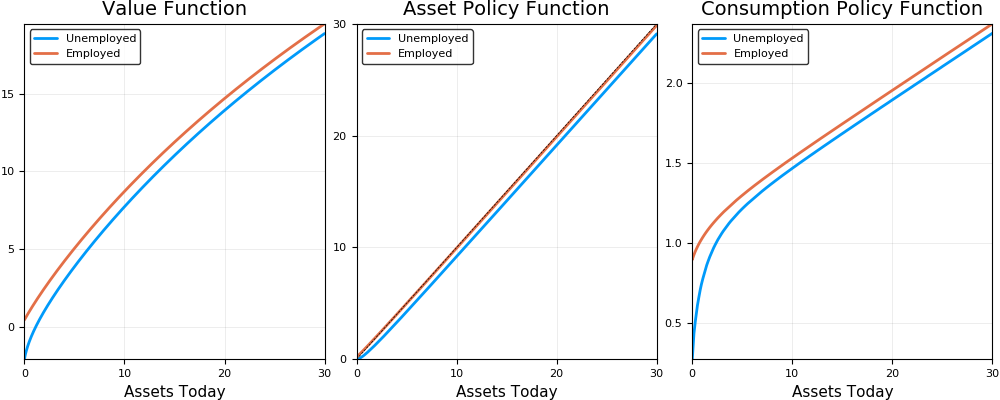

In [7]:
plot_policies(h)

## Simulation

Like the VFI algorithm, this routine is also well-suited to parallelization: in this model, the paths for each household can be simulated independently of all the other households. The only changes to be made here are again, the use of `SharedArrays` and the `@parallel` and `@sync` macros in front of the `for` loop.

In [8]:
@everywhere function simulate_h(h::Household, N::Int64=20000, T::Int64=1000, a0::Float64=20.0)
	
	srand(43)

	# Simulate Markov chain
	y_sim = Array{Int64}(T, N)
	simulate_indices!(y_sim, h.y_chain)

	# Set up matrix to store consumption and asset policies
	a_sim = SharedArray{Float64}(T+1, N)
	a_sim[1, :] = a0*ones(1, N)
	c_sim = SharedArray{Float64}(T, N)

	# Create interpolation object for final asset policy
	knots = (h.a_grid, [1, 2])
    itp_a = interpolate(knots, h.ap, (Gridded(Linear()), NoInterp()))

    @sync @parallel for n = 1:N
    	for t = 1:T

    		# Interpolate a_{t+1}
    		a_sim[t + 1, n] = itp_a[a_sim[t, n], y_sim[t, n]]
    		c_sim[t, n] = budget_constraint(a_sim[t, n], a_sim[t + 1, n], h.y_grid[y_sim[t, n]], h)

    	end
    end
    
    return a_sim, c_sim, y_sim

end 

In [10]:
@time a_sim, c_sim, y_sim = simulate_h(h)

  3.437045 seconds (23.43 k allocations: 154.569 MiB, 4.72% gc time)


([20.0 20.0 … 20.0 20.0; 19.1368 19.1368 … 19.1368 19.8942; … ; 3.40634 2.23547 … 1.72209 2.3483; 3.41484 2.27565 … 1.7816 2.38471], [1.89572 1.89572 … 1.89572 1.95575; 1.8597 1.8597 … 1.91965 1.95133; … ; 1.21043 1.13181 … 1.09085 1.14022; 1.21094 1.13478 … 1.09593 1.14283], [1 1 … 1 2; 1 1 … 2 2; … ; 2 2 … 2 2; 2 2 … 2 2])

## Further Resources

### Programming/Julia
* Type system and multiple dispatch
    * [Julia documentation: types](https://docs.julialang.org/en/stable/manual/types/)
    * [Julia documentation: methods](https://docs.julialang.org/en/stable/manual/methods/)
    * [QuantEcon lectures](https://lectures.quantecon.org/jl/types_methods.html)
* [Parallel programming](https://docs.julialang.org/en/stable/manual/parallel-computing/)

### Economics
* [Income fluctuation problem](https://lectures.quantecon.org/jl/ifp.html)
* Other approaches to solving the problem:
    * [Euler equation iteration](https://lectures.quantecon.org/jl/coleman_policy_iter.html)
    * [Endogenous grid method](https://lectures.quantecon.org/jl/egm_policy_iter.html)
* The next layer of complexity to add to this problem is endogenizing the interest rate. See [the Aiyagari model](https://lectures.quantecon.org/jl/aiyagari.html)
* The next step is to add aggregate uncertainty. See [the Krusell-Smith model](https://github.com/QuantEcon/krusell_smith_code/blob/master/KrusellSmith.ipynb)